### 1. Import Libraries

In [1]:
#!pip install feature-engine

In [2]:
import numpy as np

import pandas as pd

# sklearn imports
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer,
    StandardScaler
)
from sklearn.compose import ColumnTransformer

# feature engine imports
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures

import warnings

# plots
import matplotlib as plt
%matplotlib inline

### 2. Display Settings

In [3]:
pd.set_option("display.max_columns",None)

pd.set_option("display.max_columns",None)   with this line of code we'll be able to see all the columns even if the no. of col is larger.

In [4]:
sklearn.set_config(transform_output = "pandas")

sklearn.set_config(transform_output = "pandas") with this line of code we'll be able to get the transformer's o/p in pandas dataframe 

In [5]:
warnings.filterwarnings("ignore")

### 3. Get the Training Data

In [6]:
file_path = r"Z:\AIML Projects\sagemaker-flight-prices-prediction\data\train.csv"

t_data = pd.read_csv(file_path)
t_data

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-06,Kolkata,Banglore,08:25:00,04:40:00,1215,1.0,In-flight meal not included,8586
1,Jet Airways,2019-06-09,Kolkata,Banglore,21:10:00,09:20:00,730,1.0,In-flight meal not included,11841
2,Jet Airways,2019-05-21,New Delhi,Cochin,21:50:00,04:25:00,395,1.0,No Info,16079
3,Jet Airways,2019-03-18,Banglore,New Delhi,05:45:00,18:25:00,760,1.0,No Info,12284
4,Multiple Carriers,2019-05-27,New Delhi,Cochin,07:10:00,22:30:00,920,1.0,No Info,7878
...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,2019-03-27,New Delhi,Cochin,07:00:00,21:00:00,840,1.0,No Info,6358
636,Air Asia,2019-03-18,Kolkata,Banglore,10:20:00,12:55:00,155,0.0,No Info,4384
637,Indigo,2019-05-01,Kolkata,Banglore,15:15:00,20:05:00,290,1.0,No Info,4775
638,Indigo,2019-05-01,Chennai,Kolkata,11:35:00,14:00:00,145,0.0,No Info,4332


In [7]:
t_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [8]:
X_train = t_data.drop(columns="price")
y_train = t_data.price.copy()

### 4. Transformation Operations

#### 4.1 Feature - airline          

Airline 

* Imputation
* Group Rare Labels
* One-hot encoding

In [9]:
X_train.airline

0            Jet Airways
1            Jet Airways
2            Jet Airways
3            Jet Airways
4      Multiple Carriers
             ...        
635    Multiple Carriers
636             Air Asia
637               Indigo
638               Indigo
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [10]:
air_transformer = Pipeline(steps=[

    # With the helper of Pipeline we can do the transformations in an order of steps

    # step 1
    ("imputer",SimpleImputer(strategy="most_frequent")),

    # step 2
    ("grouper",RareLabelEncoder(tol=0.1,replace_with="Other",n_categories=2)),
    # grouping cat having percentage less than 10% only if the no of cat are 2 or more

    # step 3
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
    # to see the output we use the sparse_output=False and handle_unknown as ignore will mark unknown cat in testing as 0 only
])
air_transformer.fit_transform(X_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
635,0.0,0.0,0.0,1.0,0.0
636,0.0,0.0,0.0,0.0,1.0
637,0.0,1.0,0.0,0.0,0.0
638,0.0,1.0,0.0,0.0,0.0


#### 4.2 Feature - date_of_journey          

Date of Journey

* Date-time features
* Min Max Scaling 

In [11]:
X_train.date_of_journey

0      2019-06-06
1      2019-06-09
2      2019-05-21
3      2019-03-18
4      2019-05-27
          ...    
635    2019-03-27
636    2019-03-18
637    2019-05-01
638    2019-05-01
639    2019-06-06
Name: date_of_journey, Length: 640, dtype: object

In [12]:
features = ["month","week","day_of_week","day_of_year"]

In [13]:
# to check the documentation in jupyter notebook

In [14]:
# DatetimeFeatures??

In [15]:
doj_transformer = Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=features,yearfirst=True,format="mixed")),
    ("scaler",MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.823529,0.500000,0.822034
1,1.000000,0.823529,1.000000,0.847458
2,0.666667,0.705882,0.166667,0.686441
3,0.000000,0.176471,0.000000,0.144068
4,0.666667,0.764706,0.000000,0.737288
...,...,...,...,...
635,0.000000,0.235294,0.333333,0.220339
636,0.000000,0.176471,0.000000,0.144068
637,0.666667,0.529412,0.333333,0.516949
638,0.666667,0.529412,0.333333,0.516949


#### 4.3 Feature - Source / Destination          

Source / Destination

* Group Rare Labels
* Mean Encoding
* Power Transformation
* Is North City ?

In [16]:
X_train.source

0        Kolkata
1        Kolkata
2      New Delhi
3       Banglore
4      New Delhi
         ...    
635    New Delhi
636      Kolkata
637      Kolkata
638      Chennai
639      Kolkata
Name: source, Length: 640, dtype: object

In [17]:
X_train.destination

0       Banglore
1       Banglore
2         Cochin
3      New Delhi
4         Cochin
         ...    
635       Cochin
636     Banglore
637     Banglore
638      Kolkata
639     Banglore
Name: destination, Length: 640, dtype: object

In [18]:
location_subset = X_train.loc[:,["source","destination"]]
location_subset

,source,destination
0,Kolkata,Banglore
1,Kolkata,Banglore
2,New Delhi,Cochin
3,Banglore,New Delhi
4,New Delhi,Cochin
...,...,...
635,New Delhi,Cochin
636,Kolkata,Banglore
637,Kolkata,Banglore
638,Chennai,Kolkata


In [19]:
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1,replace_with="other",n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,-0.323771,-0.323771
1,-0.323771,-0.323771
2,1.075206,1.075206
3,-0.788371,-0.788371
4,1.075206,1.075206
...,...,...
635,1.075206,1.075206
636,-0.323771,-0.323771
637,-0.323771,-0.323771
638,-2.021146,-2.021146


Let's create a custom feature called as "Is North" for which we have to find the name of all the cities therefore:

In [20]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Hyderabad', 'Kolkata', 'Mumbai',
       'New Delhi'], dtype=object)

In [21]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["New Delhi","Kolkata","Mumbai"]
    return (
        X
        .assign(**{
            col: X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
    )
FunctionTransformer(func=is_north)


FunctionTransformer(func=<function is_north at 0x0000014343D420C0>)

In [22]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["New Delhi","Kolkata","Mumbai"]
    return (
        X
        .assign(**{
            f'{col}_is_north': X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=is_north).fit_transform(location_subset)


,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0
...,...,...
635,1,0
636,1,0
637,1,0
638,0,1


In [23]:
is_north(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0
...,...,...
635,1,0
636,1,0
637,1,0
638,0,1


In [24]:
location_transformer = FeatureUnion(transformer_list=[
    ("part1",location_pipe1),
    ("part2",FunctionTransformer(func=is_north))
])
location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,-0.323771,-0.323771,1,0
1,-0.323771,-0.323771,1,0
2,1.075206,1.075206,1,0
3,-0.788371,-0.788371,0,1
4,1.075206,1.075206,1,0
...,...,...,...,...
635,1.075206,1.075206,1,0
636,-0.323771,-0.323771,1,0
637,-0.323771,-0.323771,1,0
638,-2.021146,-2.021146,0,1


#### 4.4 Feature - dep_time	/ arrival_time      

In [25]:
X_train.dep_time

0      08:25:00
1      21:10:00
2      21:50:00
3      05:45:00
4      07:10:00
         ...   
635    07:00:00
636    10:20:00
637    15:15:00
638    11:35:00
639    08:25:00
Name: dep_time, Length: 640, dtype: object

In [26]:
X_train.arrival_time

0      04:40:00
1      09:20:00
2      04:25:00
3      18:25:00
4      22:30:00
         ...   
635    21:00:00
636    12:55:00
637    20:05:00
638    14:00:00
639    20:45:00
Name: arrival_time, Length: 640, dtype: object

In [27]:
time_subset = X_train.loc[:,['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,08:25:00,04:40:00
1,21:10:00,09:20:00
2,21:50:00,04:25:00
3,05:45:00,18:25:00
4,07:10:00,22:30:00
...,...,...
635,07:00:00,21:00:00
636,10:20:00,12:55:00
637,15:15:00,20:05:00
638,11:35:00,14:00:00


In [28]:
time_pipe1 = Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=['hour','minute'])),
    ("scalar",MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,0.454545,0.173913,0.727273
1,0.913043,0.181818,0.391304,0.363636
2,0.913043,0.909091,0.173913,0.454545
3,0.217391,0.818182,0.782609,0.454545
4,0.304348,0.181818,0.956522,0.545455
...,...,...,...,...
635,0.304348,0.000000,0.913043,0.000000
636,0.434783,0.363636,0.521739,1.000000
637,0.652174,0.272727,0.869565,0.090909
638,0.478261,0.636364,0.608696,0.000000


In [29]:
def part_of_day(X,morning=4,noon=12,eve=16,night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })
    return (
        X_temp
        .assign(**{
            f'{col}_part_of_day': np.select(
                [X_temp.loc[:,col].between(morning,noon,inclusive='left'),
                 X_temp.loc[:,col].between(noon,eve,inclusive="left"),
                 X_temp.loc[:,col].between(eve,night,inclusive='left')],
                ['morning','afternoon','evening'],
                default='night'
            )
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,morning
1,night,morning
2,night,morning
3,morning,evening
4,morning,night
...,...,...
635,morning,night
636,morning,afternoon
637,afternoon,night
638,morning,afternoon


In [30]:
time_pipe2 = Pipeline(steps=[
    ("part",FunctionTransformer(func=part_of_day)),
    ("encoder",CountFrequencyEncoder()),
    ("scalar",MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.738095
1,0.088983,0.738095
2,0.088983,0.738095
3,1.000000,0.642857
4,1.000000,1.000000
...,...,...
635,1.000000,1.000000
636,1.000000,0.000000
637,0.000000,1.000000
638,1.000000,0.000000


In [31]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1",time_pipe1),
    ("part2",time_pipe2)
])
time_transformer.fit_transform(time_subset,y_train)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.347826,0.454545,0.173913,0.727273,1.000000,0.738095
1,0.913043,0.181818,0.391304,0.363636,0.088983,0.738095
2,0.913043,0.909091,0.173913,0.454545,0.088983,0.738095
3,0.217391,0.818182,0.782609,0.454545,1.000000,0.642857
4,0.304348,0.181818,0.956522,0.545455,1.000000,1.000000
...,...,...,...,...,...,...
635,0.304348,0.000000,0.913043,0.000000,1.000000,1.000000
636,0.434783,0.363636,0.521739,1.000000,1.000000,0.000000
637,0.652174,0.272727,0.869565,0.090909,0.000000,1.000000
638,0.478261,0.636364,0.608696,0.000000,1.000000,0.000000


#### 4.5 Feature - duration      

In [32]:
X_train.duration

0      1215
1       730
2       395
3       760
4       920
       ... 
635     840
636     155
637     290
638     145
639     740
Name: duration, Length: 640, dtype: int64

In [33]:
dur = X_train.loc[:,['duration']]

In [34]:
def flight_length(X, short=0, medium=180, long=480):
    columns = X.columns.to_list()
    # Fix: Complete the dictionary comprehension
    X_temp = X.assign(**{
        col: X.loc[:, col]  # Simply use the original values
        for col in columns
    })
    return (
        X_temp
        .assign(**{
            f'{col}_flight_duration': np.select(
                [X_temp.loc[:,col].between(short, medium, inclusive='left'),
                 X_temp.loc[:,col].between(medium, long, inclusive="left"),  # Fix: 'large' to 'long'
                ],
                ['short', 'medium'],
                default='long'
            )
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=flight_length).fit_transform(dur)

,duration_flight_duration
0,long
1,long
2,medium
3,long
4,long
...,...
635,long
636,short
637,medium
638,short


In [35]:
duration_pipe1 = Pipeline(steps=[
	("cat", FunctionTransformer(func=flight_length)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_pipe1.fit_transform(dur)

,duration_flight_duration
0,2.0
1,2.0
2,1.0
3,2.0
4,2.0
...,...
635,2.0
636,0.0
637,1.0
638,0.0


In [36]:
(
    X_train
    .duration
    .quantile([0.25,0.5,0.75])
    .values
    # any no of rows but we need one column only
    .reshape(-1,1)
    .shape
)

(3, 1)

In [37]:
class RBFPercentileSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25,0.5,0.75],gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma
    def fit(self,X,y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include='number').columns.to_list()
            
        self.reference_values_ = {
            col: (
                X
                .loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
        }
        return self
    def transform(self,X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data = rbf_kernel(X.loc[:,[col]],Y=self.reference_values_[col],gamma=self.gamma),
                columns = columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)
            

In [38]:
RBFPercentileSimilarity().fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000e+00,0.0,0.000000e+00
1,0.000000e+00,0.0,0.000000e+00
2,0.000000e+00,0.0,0.000000e+00
3,0.000000e+00,0.0,0.000000e+00
4,0.000000e+00,0.0,3.876408e-43
...,...,...,...
635,0.000000e+00,0.0,0.000000e+00
636,1.691898e-10,0.0,0.000000e+00
637,0.000000e+00,0.0,0.000000e+00
638,7.187782e-28,0.0,0.000000e+00


In [39]:
RBFPercentileSimilarity(percentiles=[0.4,0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,1.668157e-314,1.000000,1.000000
1,0.000000e+00,0.000000e+00,1.000000,1.000000
2,8.328913e-85,0.000000e+00,1.000000,1.000000
3,0.000000e+00,0.000000e+00,1.000000,1.000000
4,0.000000e+00,0.000000e+00,1.000000,1.000000
...,...,...,...,...
635,0.000000e+00,0.000000e+00,1.000000,1.000000
636,0.000000e+00,0.000000e+00,0.904837,0.904837
637,2.506244e-162,0.000000e+00,1.000000,1.000000
638,0.000000e+00,0.000000e+00,0.904837,0.904837


In [40]:
duration_pipe2 = Pipeline(steps=[
    ("rbf",RBFPercentileSimilarity()),
    ("scaler",PowerTransformer())
])

duration_pipe2.fit_transform(dur)

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,-0.361432,-0.116088,-0.073618
1,-0.361432,-0.116088,-0.073618
2,-0.361432,-0.116088,-0.073618
3,-0.361432,-0.116088,-0.073618
4,-0.361432,-0.116088,-0.073618
...,...,...,...
635,-0.361432,-0.116088,-0.073618
636,-0.361432,-0.116088,-0.073618
637,-0.361432,-0.116088,-0.073618
638,-0.361432,-0.116088,-0.073618


In [41]:
def is_over(X,value=1000):
    return (
        X
        .assign(**{
            f'duration_over_{value}':X.duration.ge(value).astype(int)
        })
        .drop(columns='duration')
    )

In [42]:
duration_union = FeatureUnion(transformer_list=[
    ("part1",duration_pipe1),
    ("part2",duration_pipe2),
    ("part3",StandardScaler()),
    ('part4',FunctionTransformer(func=is_over))
])
duration_union.fit_transform(dur)

,duration_flight_duration,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration,duration_over_1000
0,2.0,-0.361432,-0.116088,-0.073618,1.103005,1
1,2.0,-0.361432,-0.116088,-0.073618,0.164457,0
2,1.0,-0.361432,-0.116088,-0.073618,-0.483818,0
3,2.0,-0.361432,-0.116088,-0.073618,0.222512,0
4,2.0,-0.361432,-0.116088,-0.073618,0.532136,0
...,...,...,...,...,...,...
635,2.0,-0.361432,-0.116088,-0.073618,0.377324,0
636,0.0,-0.361432,-0.116088,-0.073618,-0.948253,0
637,1.0,-0.361432,-0.116088,-0.073618,-0.687008,0
638,0.0,-0.361432,-0.116088,-0.073618,-0.967605,0


In [43]:
duration_transformer = Pipeline(steps=[
    ("outliers",Winsorizer(capping_method='iqr',fold=1.5)),
    ("imputer",SimpleImputer(strategy='median')),
    ('union',duration_union)
])

duration_transformer.fit_transform(X_train.loc[:,['duration']])

,duration_flight_duration,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration,duration_over_1000
0,2.0,-0.361432,-0.116088,-0.073618,1.110847,1
1,2.0,-0.361432,-0.116088,-0.073618,0.167142,0
2,1.0,-0.361432,-0.116088,-0.073618,-0.484696,0
3,2.0,-0.361432,-0.116088,-0.073618,0.225515,0
4,2.0,-0.361432,-0.116088,-0.073618,0.536841,0
...,...,...,...,...,...,...
635,2.0,-0.361432,-0.116088,-0.073618,0.381178,0
636,0.0,-0.361432,-0.116088,-0.073618,-0.951684,0
637,1.0,-0.361432,-0.116088,-0.073618,-0.689003,0
638,0.0,-0.361432,-0.116088,-0.073618,-0.971142,0


#### 4.6 Feature - total_stops

In [44]:
X_train.total_stops

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
635    1.0
636    0.0
637    1.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [45]:
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))

total_stops_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ('',FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:,["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,1.0,0
3,1.0,0
4,1.0,0
...,...,...
635,1.0,0
636,0.0,1
637,1.0,0
638,0.0,1


#### 4.7 Feature - additional_info

In [46]:
X_train.additional_info

0      In-flight meal not included
1      In-flight meal not included
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [47]:
info_pipe1 = Pipeline(steps=[
    ("grouper",RareLabelEncoder(tol=0.1,n_categories=2,replace_with="Other")),
    ("encoder",OneHotEncoder(handle_unknown="ignore",sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:,["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [48]:
def have_no_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [49]:
info_union = FeatureUnion(transformer_list=[
    ("part1",info_pipe1),
    ("part2",FunctionTransformer(func=have_no_info))
])

In [50]:
info_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="constant",fill_value="unknown")),
    ("union",info_union)
])

info_transformer.fit_transform(X_train.loc[:,["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


### 5. Column Transformer

In [51]:
column_transformer = ColumnTransformer(
    transformers=[
        ('air',air_transformer,["airline"]),
        ("doj",doj_transformer,["date_of_journey"]),
        ("loc",location_transformer,["source",'destination']),
        ("time",time_transformer,["dep_time",'arrival_time']),
        ('dur',duration_transformer,['duration']),
        ('ts',total_stops_transformer,['total_stops']),
        ('info',info_transformer,['additional_info'])
    ],
    
    remainder="passthrough")

column_transformer.fit_transform(X_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,loc__source,loc__destination,loc__source_is_north,loc__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_flight_duration,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration,dur__duration_over_1000,ts__total_stops,ts__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,-0.323771,-0.323771,1,0,0.347826,0.454545,0.173913,0.727273,1.000000,0.738095,2.0,-0.361432,-0.116088,-0.073618,1.110847,1,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,1.000000,0.847458,-0.323771,-0.323771,1,0,0.913043,0.181818,0.391304,0.363636,0.088983,0.738095,2.0,-0.361432,-0.116088,-0.073618,0.167142,0,1.0,0,1.0,0.0,0.0,1
2,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,1.075206,1.075206,1,0,0.913043,0.909091,0.173913,0.454545,0.088983,0.738095,1.0,-0.361432,-0.116088,-0.073618,-0.484696,0,1.0,0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.000000,0.144068,-0.788371,-0.788371,0,1,0.217391,0.818182,0.782609,0.454545,1.000000,0.642857,2.0,-0.361432,-0.116088,-0.073618,0.225515,0,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.666667,0.764706,0.000000,0.737288,1.075206,1.075206,1,0,0.304348,0.181818,0.956522,0.545455,1.000000,1.000000,2.0,-0.361432,-0.116088,-0.073618,0.536841,0,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,1.0,0.0,0.000000,0.235294,0.333333,0.220339,1.075206,1.075206,1,0,0.304348,0.000000,0.913043,0.000000,1.000000,1.000000,2.0,-0.361432,-0.116088,-0.073618,0.381178,0,1.0,0,0.0,1.0,0.0,0
636,0.0,0.0,0.0,0.0,1.0,0.000000,0.176471,0.000000,0.144068,-0.323771,-0.323771,1,0,0.434783,0.363636,0.521739,1.000000,1.000000,0.000000,0.0,-0.361432,-0.116088,-0.073618,-0.951684,0,0.0,1,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0.0,0.0,0.666667,0.529412,0.333333,0.516949,-0.323771,-0.323771,1,0,0.652174,0.272727,0.869565,0.090909,0.000000,1.000000,1.0,-0.361432,-0.116088,-0.073618,-0.689003,0,1.0,0,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0.0,0.0,0.666667,0.529412,0.333333,0.516949,-2.021146,-2.021146,0,1,0.478261,0.636364,0.608696,0.000000,1.000000,0.000000,0.0,-0.361432,-0.116088,-0.073618,-0.971142,0,0.0,1,0.0,1.0,0.0,0


### 6. Feature Selection 

In [52]:
# using RandomForest for feature selection

estimator = RandomForestRegressor(n_estimators=10,max_depth=3,random_state=42)

# it finds r2 score from each of the feature and there are 31 feature on which
# randomforest is used
selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring='r2',
    threshold=0.1
)

### 7. Putting it all together

In [53]:
preprocessor = Pipeline(steps=[
    ('ct',column_transformer),
    ('selector',selector)
])

preprocessor.fit_transform(X_train,y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,dur__duration_flight_duration,dur__duration,dur__duration_over_1000,ts__total_stops,ts__is_direct_flight
0,0.0,1.0,0.0,0.823529,0.822034,2.0,1.110847,1,1.0,0
1,0.0,1.0,0.0,0.823529,0.847458,2.0,0.167142,0,1.0,0
2,0.0,1.0,0.0,0.705882,0.686441,1.0,-0.484696,0,1.0,0
3,0.0,1.0,0.0,0.176471,0.144068,2.0,0.225515,0,1.0,0
4,0.0,0.0,0.0,0.764706,0.737288,2.0,0.536841,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.235294,0.220339,2.0,0.381178,0,1.0,0
636,0.0,0.0,1.0,0.176471,0.144068,0.0,-0.951684,0,0.0,1
637,1.0,0.0,0.0,0.529412,0.516949,1.0,-0.689003,0,1.0,0
638,1.0,0.0,0.0,0.529412,0.516949,0.0,-0.971142,0,0.0,1


### 7. Visualizations

In [54]:
preprocessor

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_no_info at 0x0000014343D77CE0>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [55]:
preprocessor.named_steps

{'ct': ColumnTransformer(remainder='passthrough',
                   transformers=[('air',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('grouper',
                                                   RareLabelEncoder(n_categories=2,
                                                                    replace_with='Other',
                                                                    tol=0.1)),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  ['airline']),
                                 ('doj',
                                  Pipeline(steps=[('dt',
                                                   

In [56]:
preprocessor.named_steps.keys()

dict_keys(['ct', 'selector'])

In [57]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(-0.008251438879737893),
 'air__airline_Indigo': np.float64(0.12041247568566212),
 'air__airline_Jet Airways': np.float64(0.18251482338581956),
 'air__airline_Multiple Carriers': np.float64(0.0061282353044072035),
 'air__airline_Other': np.float64(0.10238954143951418),
 'doj__date_of_journey_month': np.float64(0.09931530603615535),
 'doj__date_of_journey_week': np.float64(0.16617442254337622),
 'doj__date_of_journey_day_of_week': np.float64(-0.006984569176674597),
 'doj__date_of_journey_day_of_year': np.float64(0.2405322045843339),
 'loc__source': np.float64(0.07871846339454347),
 'loc__destination': np.float64(0.07871846339454347),
 'loc__source_is_north': np.float64(0.017923966165991345),
 'loc__destination_is_north': np.float64(0.017923966165991345),
 'time__dep_time_hour': np.float64(-0.012191566676599338),
 'time__dep_time_minute': np.float64(0.012172017738508586),
 'time__arrival_time_hour': np.float64(0.04780080419956878),
 'time__arrival_tim

In [58]:
sorted_fea_imp = dict(sorted(feature_performances.items(),key=lambda val: val[1]))
sorted_fea_imp

{'dur__duration_rbf_50': np.float64(-0.04030326568917101),
 'time__dep_time_hour': np.float64(-0.012191566676599338),
 'air__airline_Air India': np.float64(-0.008251438879737893),
 'doj__date_of_journey_day_of_week': np.float64(-0.006984569176674597),
 'info__additional_info_No Info': np.float64(-0.005685133438164014),
 'info__additional_info': np.float64(-0.005685133438164014),
 'time__dep_time_part_of_day': np.float64(-0.005611709995448429),
 'info__additional_info_In-flight meal not included': np.float64(-0.004127061678570502),
 'dur__duration_rbf_75': np.float64(-0.003988022647981149),
 'air__airline_Multiple Carriers': np.float64(0.0061282353044072035),
 'info__additional_info_Other': np.float64(0.00626012244657026),
 'time__dep_time_minute': np.float64(0.012172017738508586),
 'time__arrival_time_minute': np.float64(0.01416749593244985),
 'loc__source_is_north': np.float64(0.017923966165991345),
 'loc__destination_is_north': np.float64(0.017923966165991345),
 'time__arrival_time_p

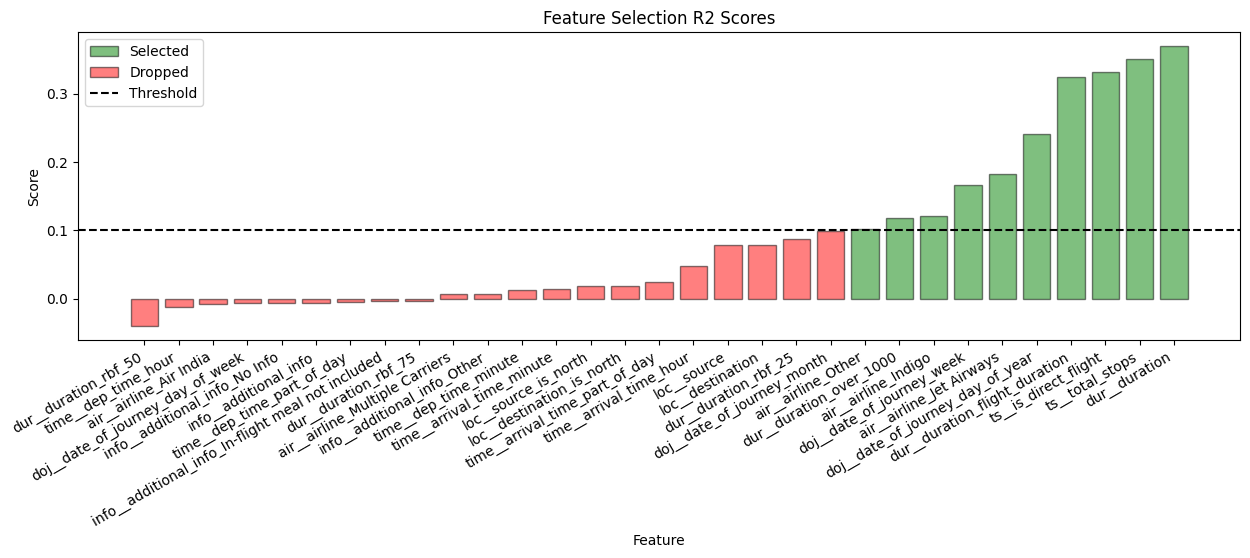

In [59]:
# visual approach

th = 0.1 # threshold
selected_bar = None
dropped_bar = None
colors = ["red" if score < th else "green" for score in sorted_fea_imp.values()]

fig,ax=plt.pyplot.subplots(figsize=(15,4))

for i ,(feature,score) in enumerate(sorted_fea_imp.items()):
    params = dict(
        x=i,
        height=score,
        edgecolor='black',
        alpha=0.5
    )
    if score < th:
        bar = ax.bar(
            color='red',
            **params
        )
        if not dropped_bar:
            dropped_bar=bar[0]
    else:
        bar=ax.bar(
            color='green',
            **params
        )
        if not selected_bar:
            selected_bar=bar[0]

thresh_line = ax.axhline(
    y=0.1,
    color='black',
    linestyle='--'
)

ax.set_xticks(
    ticks=range(len(sorted_fea_imp)),
    labels= list(sorted_fea_imp.keys()),
    rotation=30,
    ha='right'
)

ax.set(
    xlabel='Feature',
    ylabel='Score',
    title='Feature Selection R2 Scores'
)

ax.legend(
    handles = [selected_bar, dropped_bar, thresh_line],
    labels= ["Selected",'Dropped','Threshold'],
    loc='upper left'
)
plt.pyplot.show()

In [3]:
# !pip install pandas>=2.2.2
# !pip install feature-engine>=1.8.3

# import pandas as pd
# import feature_engine

# print(f"Pandas version: {pd.__version__}")
# print(f"Feature Engine version: {feature_engine.__version__}")